<a href="https://colab.research.google.com/github/taliafabs/sta365-winter2025/blob/main/sta365hw9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STA365 Week 11
Homework $\#$9
March 25, 2025

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pymc as pm
import sklearn
import pandas as pd
import seaborn as sns
import arviz as az
import pytensor.tensor as pt
from scipy.stats import expon, multivariate_normal, norm

## Q1: Copulas

1. Use the example copula code below to provide posterior inference on the dependency structure between for **your own non normally distributed data that you find** -- removed from hw!!!

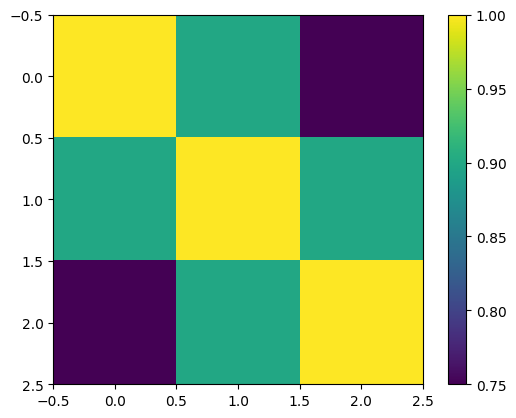

In [47]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

p = 3
#Psi = np.eye(p)
#a_cov = stats.invwishart(df=p+2, scale=Psi).rvs()
a_cor = (np.ones((p,p))*9+np.diag((1,1,1)))/10
a_cor[0,-1] -= 0.15
a_cor[-1,0] -= 0.15

n = 100
x = stats.multivariate_normal(mean=np.zeros(p), cov=a_cor).rvs(size=n)
plt.imshow(a_cor)
plt.colorbar();

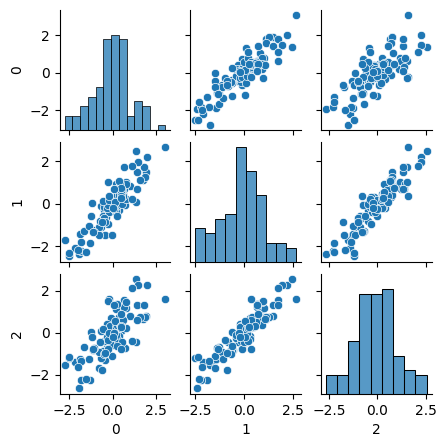

In [48]:
import seaborn
import pandas as pd
seaborn.pairplot(pd.DataFrame(x),height=1.5);

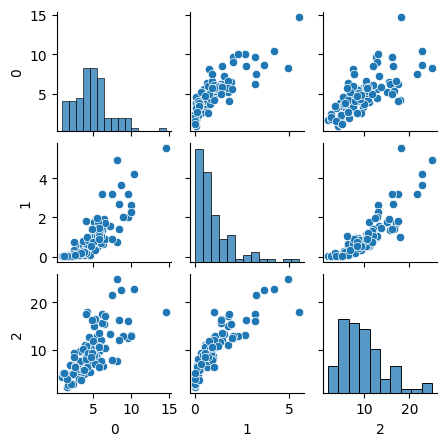

In [49]:
y = x.copy()
y[:,0] = stats.gamma(a=5).ppf(stats.norm().cdf(x[:,0]))
y[:,1] = stats.expon(scale=1).ppf(stats.norm().cdf(x[:,1]))
y[:,2] = stats.chi2(df=10).ppf(stats.norm().cdf(x[:,2]))

seaborn.pairplot(pd.DataFrame(y),height=1.5)

In [ ]:
import pymc as pm
import arviz as az

with pm.Model() as copula:

    p0 = pm.HalfNormal('p0', sigma=10)
    y0 = pm.Gamma('y0', alpha=p0, beta=1, observed=y[:,0:1])
    y0_ = pm.Deterministic('y0_',
            pm.Normal.icdf(
               pm.math.exp(pm.Gamma.logcdf(y0, alpha=p0, beta=1)),
                           mu=0, sigma=1)
            )

    p1 = pm.HalfNormal('p1', sigma=10)
    y1 = pm.Exponential('y1', lam=p1, observed=y[:,1:2])
    y1_ = pm.Deterministic('y1_',
            pm.Normal.icdf(
               pm.math.exp(pm.Exponential.logcdf(y1, mu=p1)),
                           mu=0, sigma=1))

    p2 = pm.HalfNormal('p2', sigma=10)
    y2 = pm.ChiSquared('y2', nu=p2, observed=y[:,2:3])
    y2_ = pm.Deterministic('y2_',
            pm.Normal.icdf(
               pm.math.exp(pm.ChiSquared.logcdf(y2, nu=p2)),
                           mu=0, sigma=1))

    L,R,stds = pm.LKJCholeskyCov("R", n=3, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=3),
                                 compute_corr=True)

    potential = pm.Potential("MVNeval",
                             pm.logp(pm.MvNormal.dist(mu=0, cov=R),
                             pm.math.concatenate([y0_,y1_,y2_], axis=1)))

    idata = pm.sample()

# This probally produces a lot of warnings but it will run and provide inference

2. Repeat the exercise using instead a two pass approach in the manner of https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html

Note: a lot of the code below is from the provided link. I borrow a lot of that code but use the normalized california housing data as my x.

In [44]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
california_df = pd.DataFrame(housing.data, columns=housing.feature_names)

x = california_df.values
x = (x - x.mean(axis=0)) / x.std(axis=0)

In [45]:
# code from the pymc copula estimation example
coords = {"obs_id": np.arange(len(a))}
rng = np.random.default_rng(123)
b_scale = 2
theta = {"a_dist": norm(), "b_dist": expon(scale=1 / b_scale), "rho": 0.9}
n_samples=3000
mu = [0, 0]
cov = [[1, theta["rho"]], [theta["rho"], 1]]
a_norm = x[:, 0]
b_norm = x[:, 1]
a_unif = norm(loc=0, scale=1).cdf(a_norm)
b_unif = norm(loc=0, scale=1).cdf(b_norm)
a = theta["a_dist"].ppf(a_unif)
b = theta["b_dist"].ppf(b_unif)


Output()

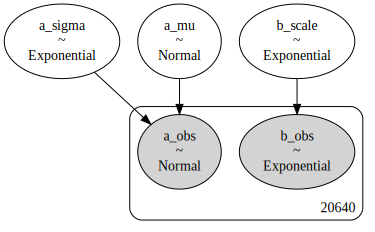

In [46]:
with pm.Model() as pymc_copula:
  a_mu = pm.Normal('a_mu', mu=0, sigma=1)
  a_sigma = pm.Exponential('a_sigma', lam=0.5)
  a_obs = pm.Normal('a_obs', mu=a_mu, sigma=a_sigma, observed=a)
  b_scale = pm.Exponential('b_scale', lam=0.5)
  b_obs = pm.Exponential('b_obs', lam=1/b_scale, observed=b)
  idata_pymc_copula = pm.sample(random_seed = np.random.default_rng(123))

pm.model_graph.model_to_graphviz(pymc_copula)

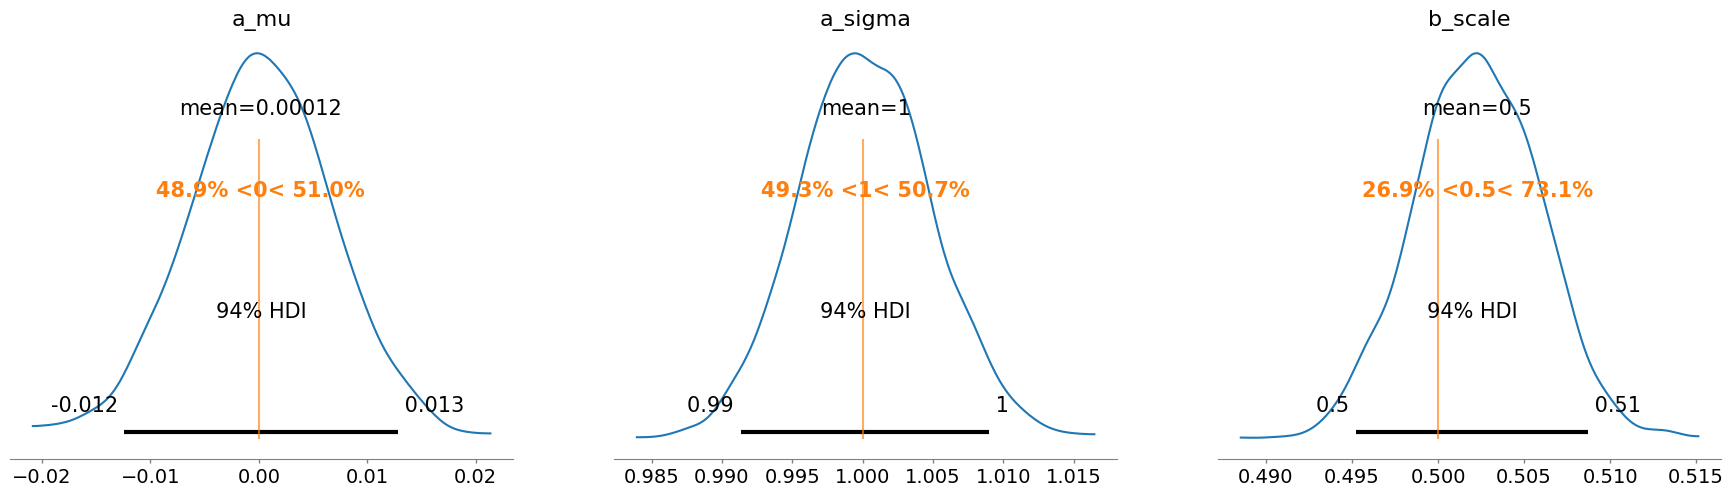

In [47]:
az.plot_posterior(
    idata_pymc_copula, var_names=["a_mu", "a_sigma", "b_scale"], ref_val=[0, 1.0, 1 / 2.0]
);

In [48]:
# transforming the data
# source: https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html
def transform_data(idata):
    # point estimates
    a_mu = idata_pymc_copula.posterior["a_mu"].mean().item()
    a_sigma = idata_pymc_copula.posterior["a_sigma"].mean().item()
    b_scale = idata_pymc_copula.posterior["b_scale"].mean().item()
    # transformations from observation space -> uniform space
    __a = pt.exp(pm.logcdf(pm.Normal.dist(mu=a_mu, sigma=a_sigma), a))
    __b = pt.exp(pm.logcdf(pm.Exponential.dist(lam=1 / b_scale), b))
    # uniform space -> multivariate normal space
    _a = pm.math.probit(__a)
    _b = pm.math.probit(__b)
    # join into an Nx2 matrix
    data = pt.math.stack([_a, _b], axis=1).eval()
    return data, a_mu, a_sigma, b_scale


data, a_mu, a_sigma, b_scale = transform_data(idata_pymc_copula) # second pass transforming the data

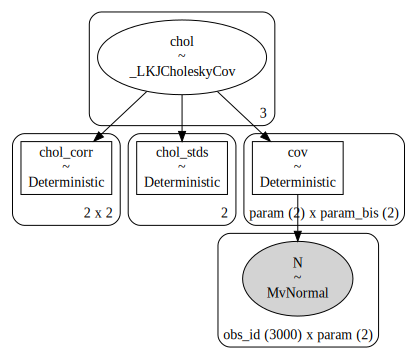

In [49]:
# updating the coordinates
# source: https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html
coords.update({"param": ["a", "b"], "param_bis": ["a", "b"]})
with pm.Model(coords=coords) as copula2:
    # Prior on covariance of the multivariate normal
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol",
        n=2,
        eta=2.0,
        sd_dist=pm.Exponential.dist(1.0),
        compute_corr=True,
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T), dims=("param", "param_bis"))

    # Likelihood function
    pm.MvNormal("N", mu=0.0, cov=cov, observed=data, dims=("obs_id", "param"))

pm.model_graph.model_to_graphviz(copula2)


In [50]:
with copula2:
    idata_copula2 = pm.sample(random_seed=rng, tune=2000, cores=1)

az.plot_posterior(idata_copula2, var_names=["cov"], ref_val=[1.0, theta["rho"], theta["rho"], 1.0]);

Output()

ValueError: conflicting sizes for dimension 'obs_id': length 20640 on the data but length 3000 on coordinate 'obs_id'

3. Describe what a copula is and how the two versions of code implement it
* a copula is a function that describes the dependence between two random variables without needing to specify the marginals of each variable.
* we can use copulasa to model the joint over multiple variables while keeping individual distributions separate.
* the code provided in the lecture notebook (shown in 1.1) implements a copula by
* in 1.2, the code implements a copula by

4. Describe how to use this to create arbitrary multivariate GLM regressions

## Q2: Variable selection using spike and slab
Perform multivarite regression (or multivariate probit classification) with spike and slab variable selection priors and compare inference to analagous inference with diffuse normal priors (imposing minimal L2 style regularization on the likelihood).

You may artificially limit the size of your data to reduce the computational demands, but if you do so, discuss the behavior of the computational demands with respect to the number of observations $n$, the number of random variables $m$ making up the multivariate observations, and the number of columns of the design matrix $p$.

In [4]:
# california housing dataset
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [5]:
# prepare the dataset
california_dataset = pd.DataFrame(housing.data, columns=housing.feature_names)
california_dataset['MedHouseVal'] = housing.target

# artificially limit the siz of the data to 100 observations
california_dataset_reduced =  california_dataset.sample(n=100, random_state=365)

# construct X and Y
features = ['HouseAge', 'AveRooms', 'Latitude', 'Longitude', 'Population']
targets = ['MedInc', 'MedHouseVal']

X = california_dataset_reduced[features].values
Y = california_dataset_reduced[targets].values

# normalize the data
X = (X - X.mean(axis=0)) / X.std(axis=0)
Y = (Y - Y.mean(axis=0)) / Y.std(axis=0)

n, p = X.shape # num data points, num features
m = Y.shape[1] # num random variables

print(f"n = {n}, p = {p}, m = {m}")

n = 100, p = 5, m = 2


In [12]:
with pm.Model() as spike_and_slab:

  # spike and slab priors
  prob = pm.Beta('prob', alpha=1, beta=1, shape=(p,m))
  spike = pm.Bernoulli('spike', p=prob, shape=(p,m))
  slab = pm.Normal('slab', mu=0, sigma=10, shape=(p,m))

  # multivariate regression
  packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=m),
                                 compute_corr=False)

  L = pm.expand_packed_triangular(m, packed_L)

  beta0 = pm.Normal('beta0', mu=0, sigma=100, shape=m)
  # using spike and slab priors for beta
  betas = pm.Deterministic('betas', spike * slab) # element-wise operation

  Sigma = pm.Deterministic('Sigma', L.dot(L.T)) # LKJ prior for sigma

  mu = beta0 + pm.math.dot(X, betas)

  Y_obs = pm.MvNormal('Y_obs',
                      mu=mu,
                      cov=Sigma,
                      observed=Y)

  # draw samples
  idata_spike_and_slab = pm.sample(3000,
                                   return_inferencedata=True,
                                   target_accept=0.95)

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:There were 1685 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [13]:
az.summary(idata_spike_and_slab)

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",0.582,0.117,0.407,0.791,0.058,0.003,4.0,62.0,1.42
"Sigma[0, 1]",0.338,0.112,0.176,0.553,0.055,0.026,5.0,88.0,1.34
"Sigma[1, 0]",0.338,0.112,0.176,0.553,0.055,0.026,5.0,88.0,1.34
"Sigma[1, 1]",0.769,0.159,0.518,1.048,0.073,0.042,6.0,31.0,1.24
beta0[0],0.010,0.077,-0.144,0.128,0.008,0.002,103.0,1016.0,1.01
beta0[1],0.005,0.084,-0.157,0.145,0.007,0.002,171.0,1560.0,1.01
"betas[0, 0]",-0.015,0.047,-0.126,-0.000,0.007,0.010,48.0,49.0,1.04
"betas[0, 1]",0.022,0.055,0.000,0.139,0.010,0.009,34.0,25.0,1.05
"betas[1, 0]",0.597,0.071,0.454,0.721,0.023,0.003,9.0,102.0,1.15
"betas[1, 1]",0.006,0.034,0.000,0.000,0.005,0.012,54.0,53.0,1.03


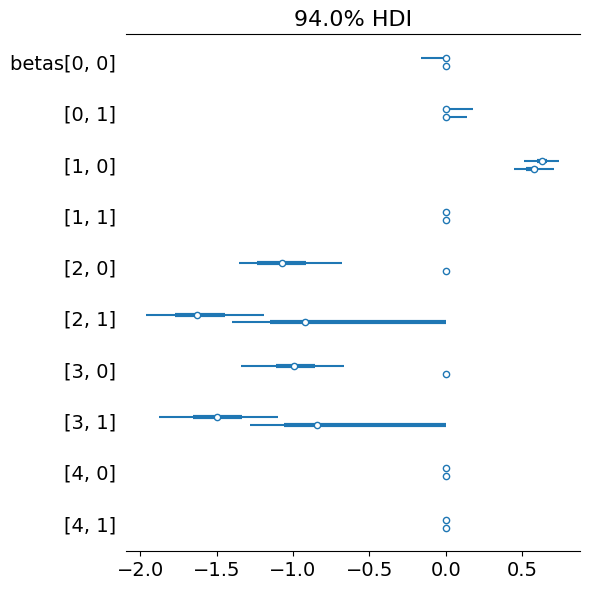

In [14]:
az.plot_forest(idata_spike_and_slab, var_names=['betas'])
plt.tight_layout()
plt.show()

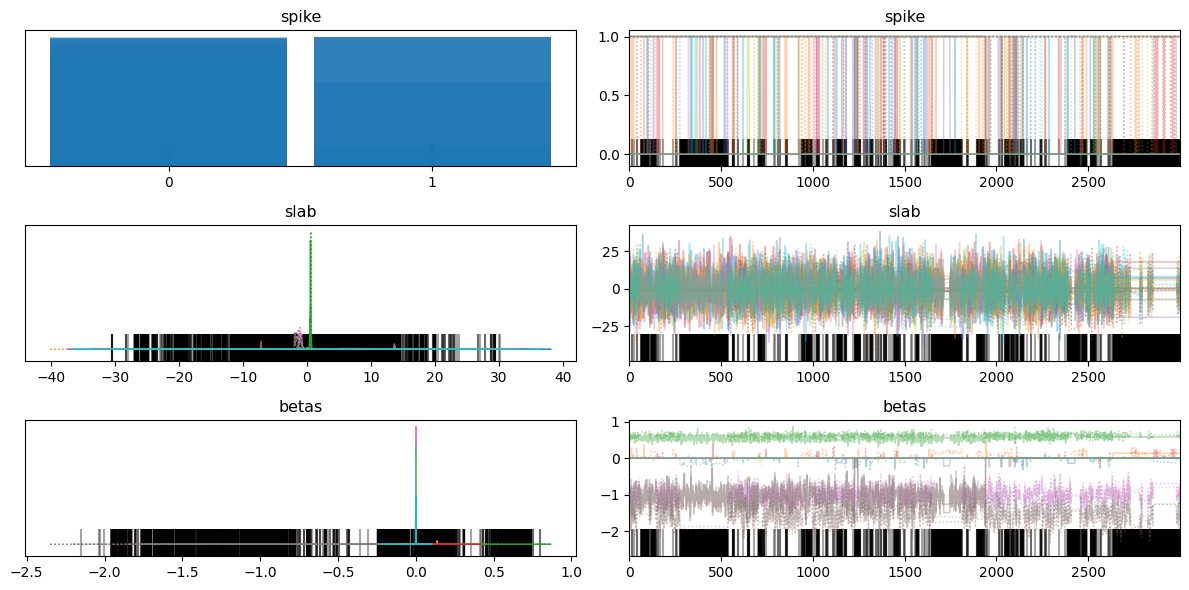

In [17]:
# trace plots
az.plot_trace(idata_spike_and_slab, var_names=['spike', 'slab', 'betas'])
plt.tight_layout()
plt.show()

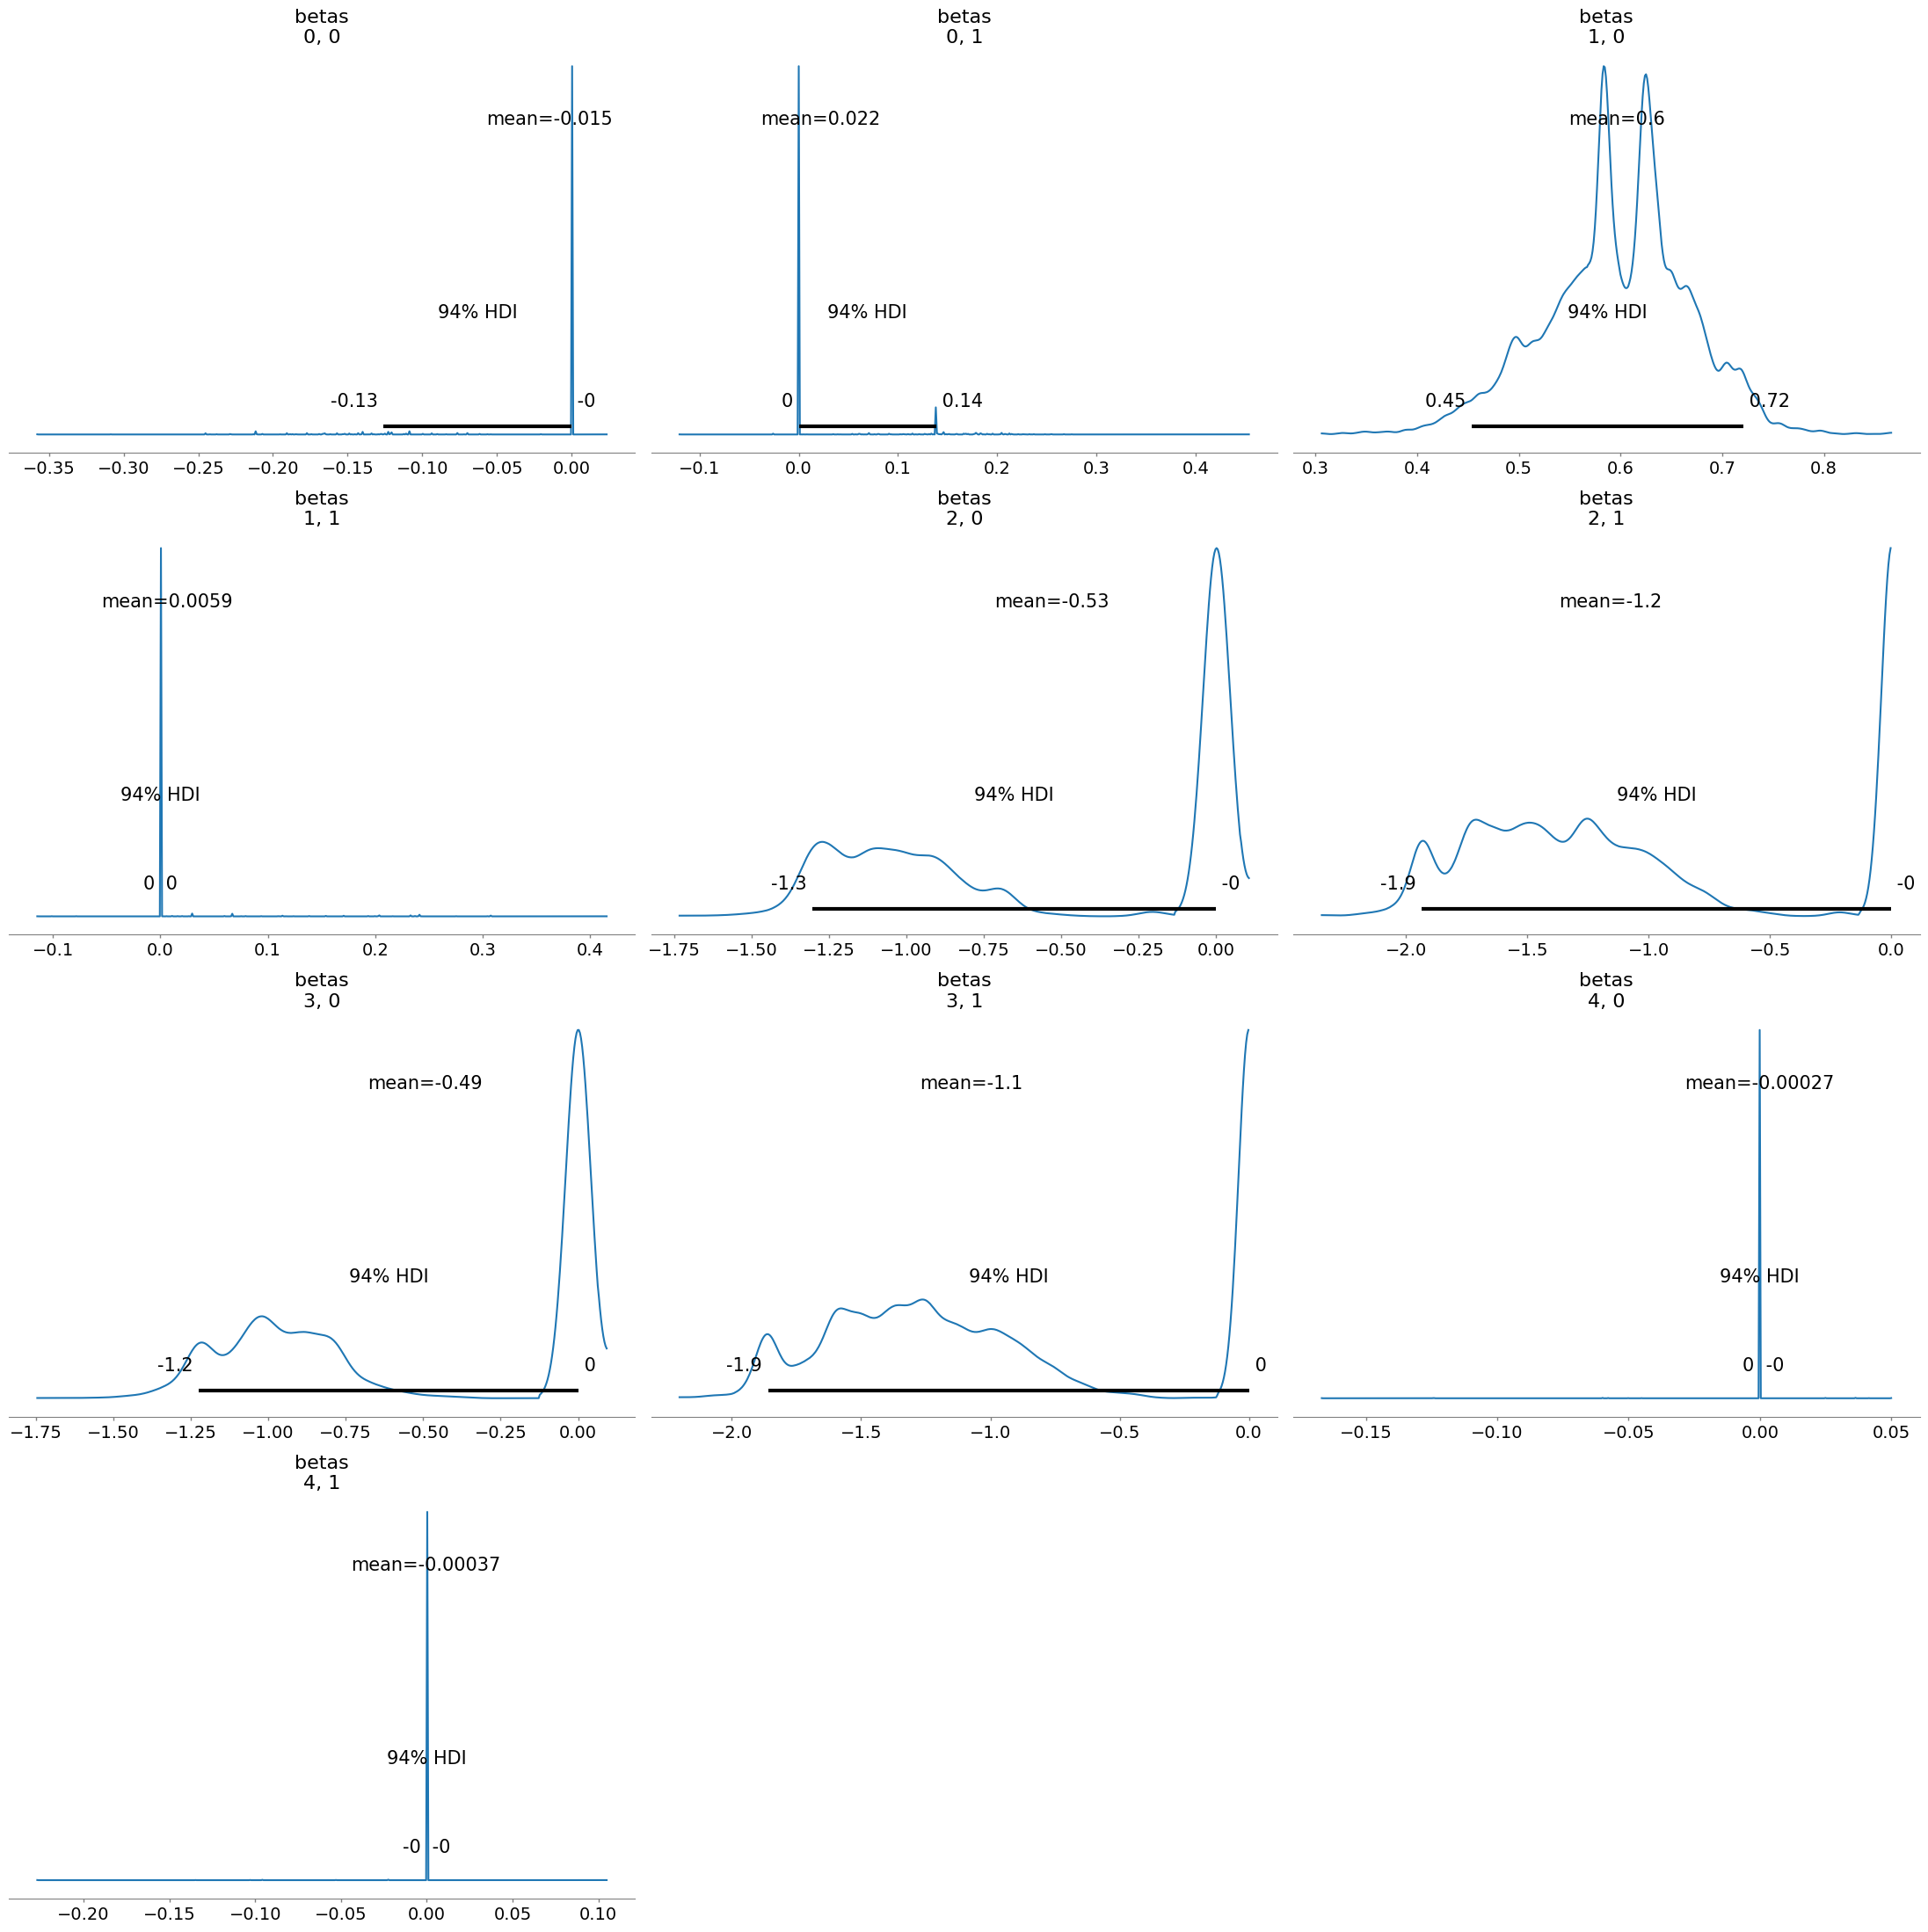

In [19]:
az.plot_posterior(idata_spike_and_slab, var_names=['betas'])
plt.tight_layout()
plt.show()

In [20]:
# rough code, scratch cell
# Multivariate regression with spike and slab variable selection priors
# with pm.Model() as spike_slab:
#   # spike and slab priors
#   prob = pm.Beta('prob', alpha=1, beta=1, shape=(p,m))
#   spike = pm.Bernoulli('spike', p=prob, shape=(p,m)) # not t
#   slab = pm.Normal('slab', mu=0, sigma=10, shape=(p,m))

#   # betas
#   beta0 = pm.Normal('beta0', mu=0, sigma=100, shape=m)
#   betas = pm.Deterministic('betas', spike * slab) # spike and slab priors

#   sigma = pm.HalfNormal('sigma', sigma=1)
#   mu = beta0 + pm.math.dot(X, betas)
#   Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
#   idata_spike_slab = pm.sample(6000, tune=1000, return_inferencedata=True, target_accept=0.95)

In [21]:
# Multivariate regression with diffuse normal proirs
with pm.Model() as diffuse_normal:
  l2_reg = pm.HalfNormal('l2_reg', sigma=10)
  beta0 = pm.Normal('beta0', mu=0, sigma=10, shape=m)
  betas = pm.Normal('betas', mu=0, sigma=10, shape=(p, m)) # sigma=10 for weak regularization
  sigma = pm.HalfNormal('sigma', sigma=1)
  mu = beta0 + pm.math.dot(X, betas)
  Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
  idata_diffuse_normal = pm.sample(3000,
                                   return_inferencedata=True,
                                   target_accept=0.95)

Output()

In [22]:
az.summary(idata_diffuse_normal)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0[0],0.001,0.076,-0.134,0.155,0.001,0.001,6175.0,4191.0,1.0
beta0[1],0.000,0.076,-0.146,0.141,0.001,0.001,6082.0,3880.0,1.0
"betas[0, 0]",-0.148,0.081,-0.302,-0.002,0.001,0.001,6098.0,4402.0,1.0
"betas[0, 1]",0.080,0.083,-0.076,0.235,0.001,0.001,6931.0,4871.0,1.0
"betas[1, 0]",0.675,0.080,0.534,0.832,0.001,0.001,7068.0,4512.0,1.0
"betas[1, 1]",0.180,0.081,0.032,0.334,0.001,0.001,5976.0,4488.0,1.0
"betas[2, 0]",-1.167,0.222,-1.567,-0.735,0.003,0.003,4544.0,3810.0,1.0
"betas[2, 1]",-1.654,0.221,-2.063,-1.237,0.003,0.003,4349.0,4029.0,1.0
"betas[3, 0]",-1.089,0.220,-1.499,-0.680,0.003,0.003,4469.0,4072.0,1.0
"betas[3, 1]",-1.517,0.219,-1.923,-1.109,0.003,0.003,4338.0,3906.0,1.0


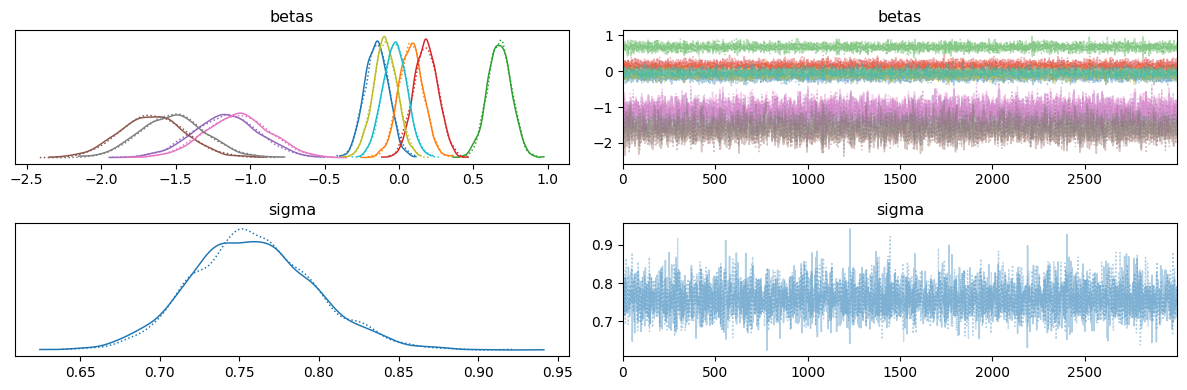

In [26]:
az.plot_trace(idata_diffuse_normal, var_names=['betas', 'sigma'])
plt.tight_layout()
plt.show()

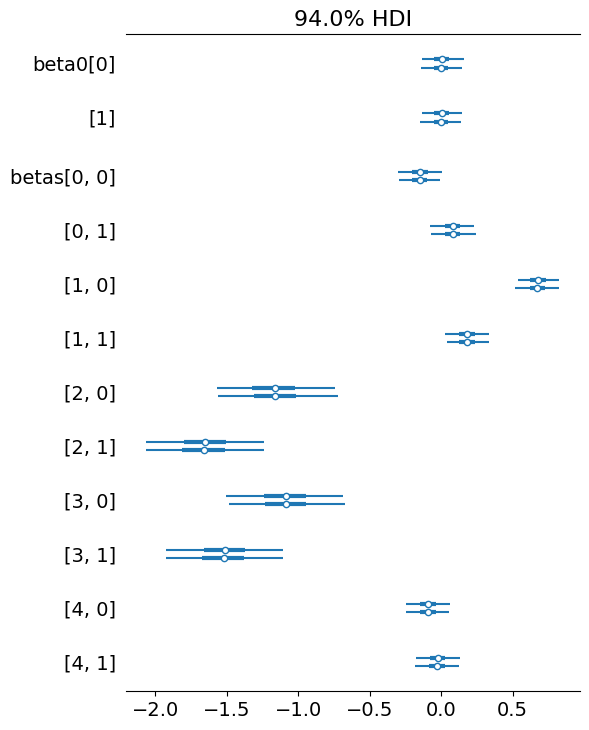

In [24]:
az.plot_forest(idata_diffuse_normal, var_names=['beta0', 'betas'])
plt.tight_layout()
plt.show()

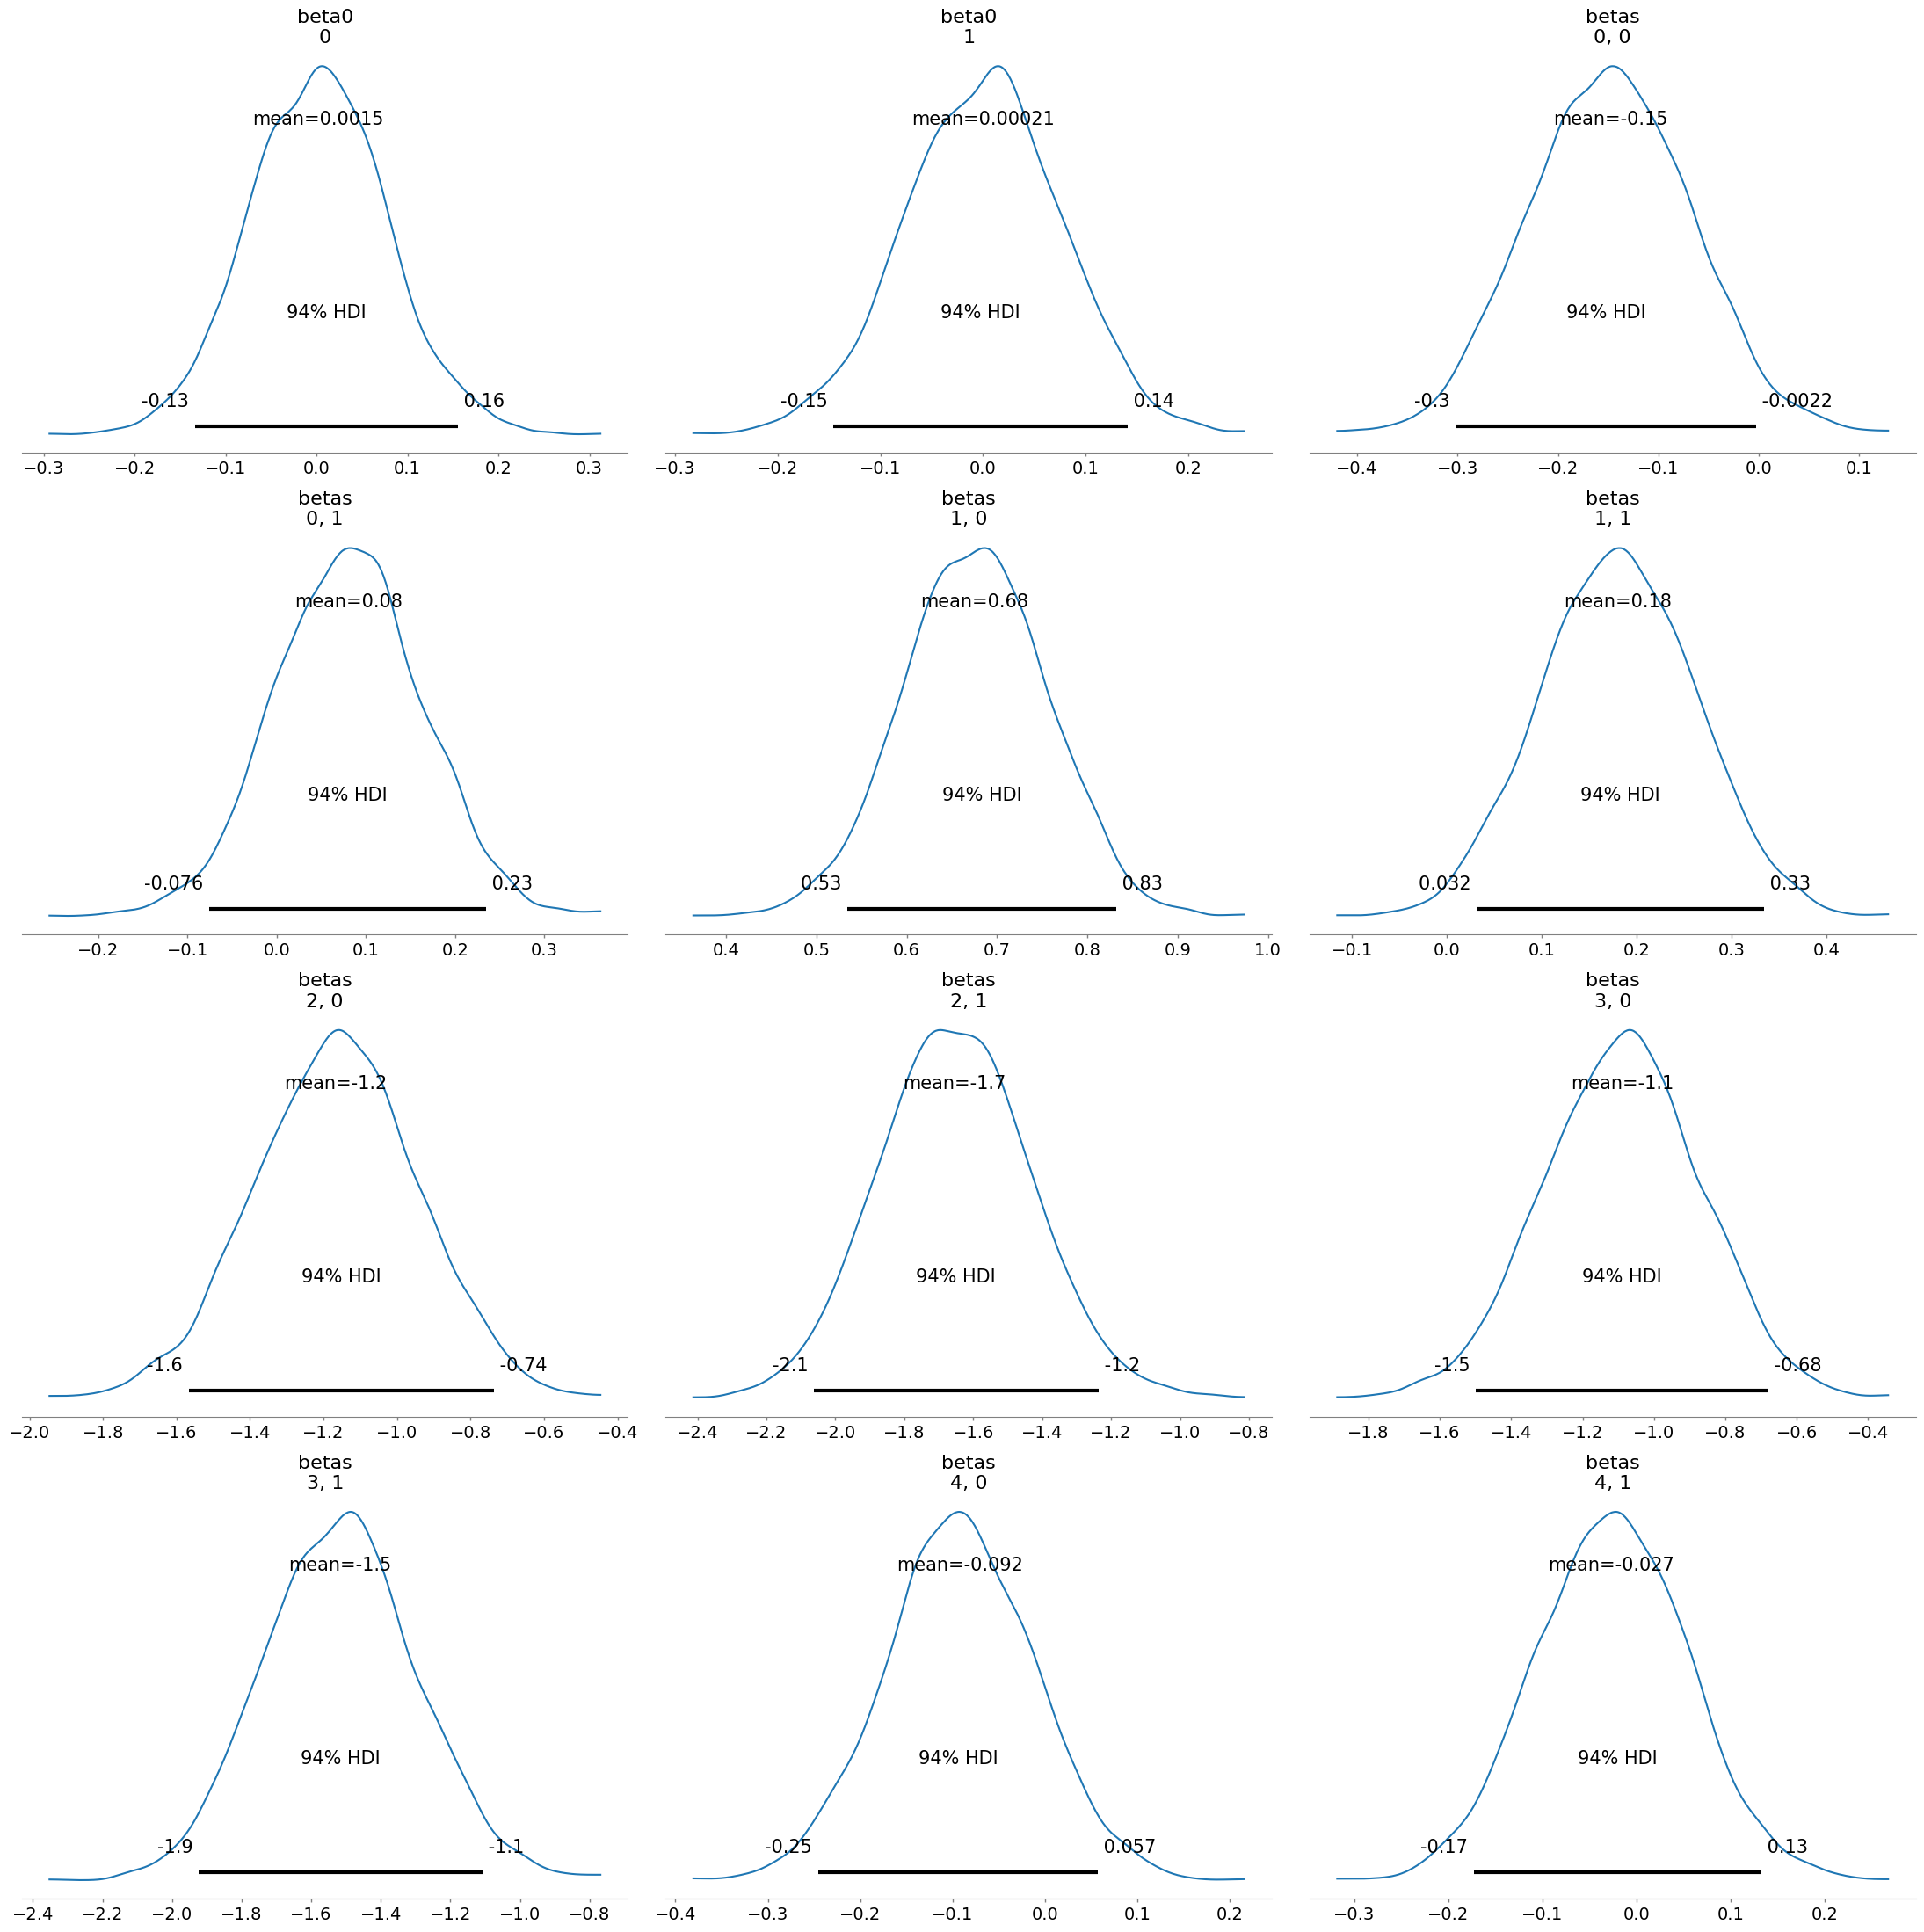

In [25]:
az.plot_posterior(idata_diffuse_normal, var_names=['beta0', 'betas',])
plt.tight_layout()
plt.show()

Discussion:
* I had to artificially limit the size of my dataset to n=100 because using the full California housing dataset (with over 20,000 data points) took hours to run.
* As the number of data points (***n***), number of features aka columns in the design matrix (***p***), and number of random variables (***m***) increases, so do the computational demands.
* Bayesian multivariate regression involves matrix multiplication $X\beta$, where X is the $n \times p$ data matrix and $\beta$ is the $p \times m$ feature matrix. this matrix operation takes $np^2m$ total add-multiply operations. The likelihood evaluation involves evaluating the multivariate normal distribution, and in PyMC we use NUTS to sample from the posterior. Overall complexity of this, combining all the matrix multiplication, multivariate likelihood evaluation, and covariance matrix operations is $O(n \cdot (p+m^2)+m^3)$
* As $n$ increases, log-likelihood becomes more computationally expensive.
* If n is small, but p is large (i.e. overparameterized model), it is prone to overfitting. if $n$ is large, then sampling will be slower due to more expensive likelihood evals. if $m$ is large, covariance operations (i.e. matrix inversions) will get expensive.

## Q3: Variable selection
Perform multivarite regression (or multivariate probit classification) with the horseshoe variable selection prior and compare inference to analagous inference with spike and slab priors.

The horseshoe variable selection prior is introduced here
- https://www.pymc.io/projects/docs/en/v5.6.0/learn/core_notebooks/pymc_overview.html
- and searches for "horseshoe prior pymc" on google produce additional examples


In [84]:
# multivariate regression with the horseshoe variable selection prior
with pm.Model() as horseshoe:
  tau = pm.HalfCauchy('tau', beta=1)
  lambda_ = pm.HalfCauchy('lambda_', beta=1, shape=(p, m))
  betas = pm.Normal('betas', mu=0, sigma = tau * lambda_, shape=(p, m))
  mu = pm.math.dot(X, betas)
  sigma = pm.HalfNormal('sigma', sigma=10, shape=m)
  Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
  idata_horseshoe = pm.sample(6000, tune=1000, return_inferencedata=True, target_accept=0.95)

Output()

ERROR:pymc.stats.convergence:There were 839 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [85]:
az.summary(idata_horseshoe)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",-0.100,0.076,-0.242,0.027,0.004,0.001,342.0,7924.0,1.01
"betas[0, 1]",0.063,0.077,-0.066,0.217,0.001,0.001,2999.0,8167.0,1.00
"betas[1, 0]",0.670,0.077,0.536,0.815,0.006,0.004,182.0,130.0,1.01
"betas[1, 1]",0.138,0.087,-0.010,0.301,0.003,0.001,877.0,3697.0,1.00
"betas[2, 0]",-1.036,0.214,-1.415,-0.617,0.006,0.002,1306.0,2182.0,1.00
"betas[2, 1]",-1.524,0.244,-1.971,-1.073,0.009,0.002,869.0,6532.0,1.00
"betas[3, 0]",-0.960,0.214,-1.351,-0.564,0.007,0.002,855.0,5442.0,1.00
"betas[3, 1]",-1.391,0.243,-1.849,-0.954,0.008,0.002,943.0,6488.0,1.00
"betas[4, 0]",-0.057,0.069,-0.195,0.057,0.002,0.001,1221.0,3326.0,1.00
"betas[4, 1]",-0.022,0.070,-0.170,0.102,0.001,0.001,2385.0,7079.0,1.00


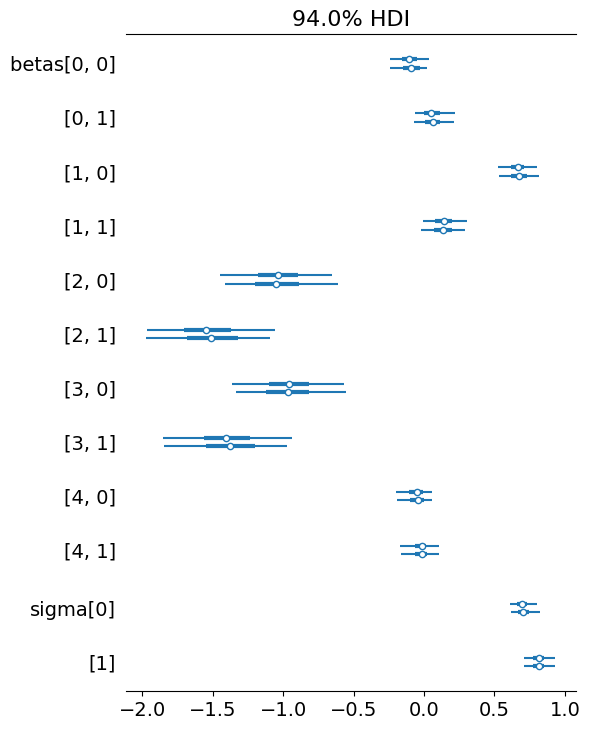

In [86]:
az.plot_forest(idata_horseshoe, var_names=['betas', 'sigma'])
plt.tight_layout()
plt.show()

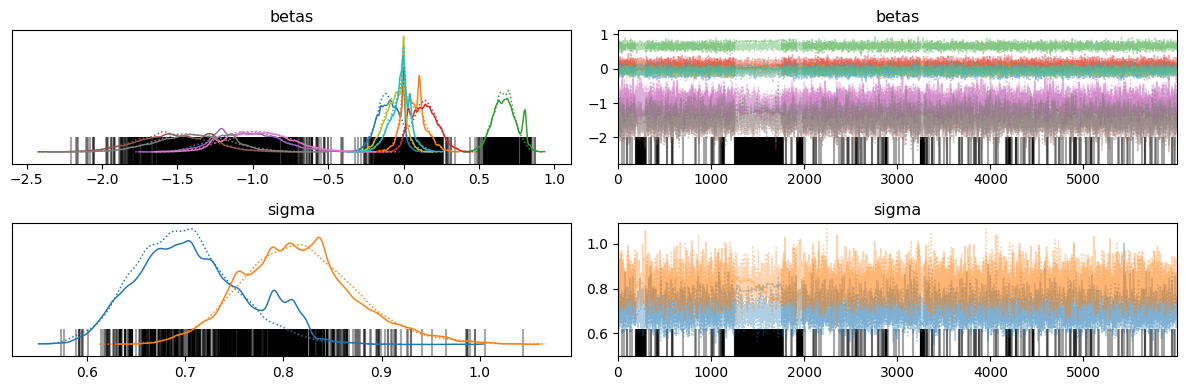

In [87]:
az.plot_trace(idata_horseshoe, var_names=['betas', 'sigma'])
plt.tight_layout()
plt.show()

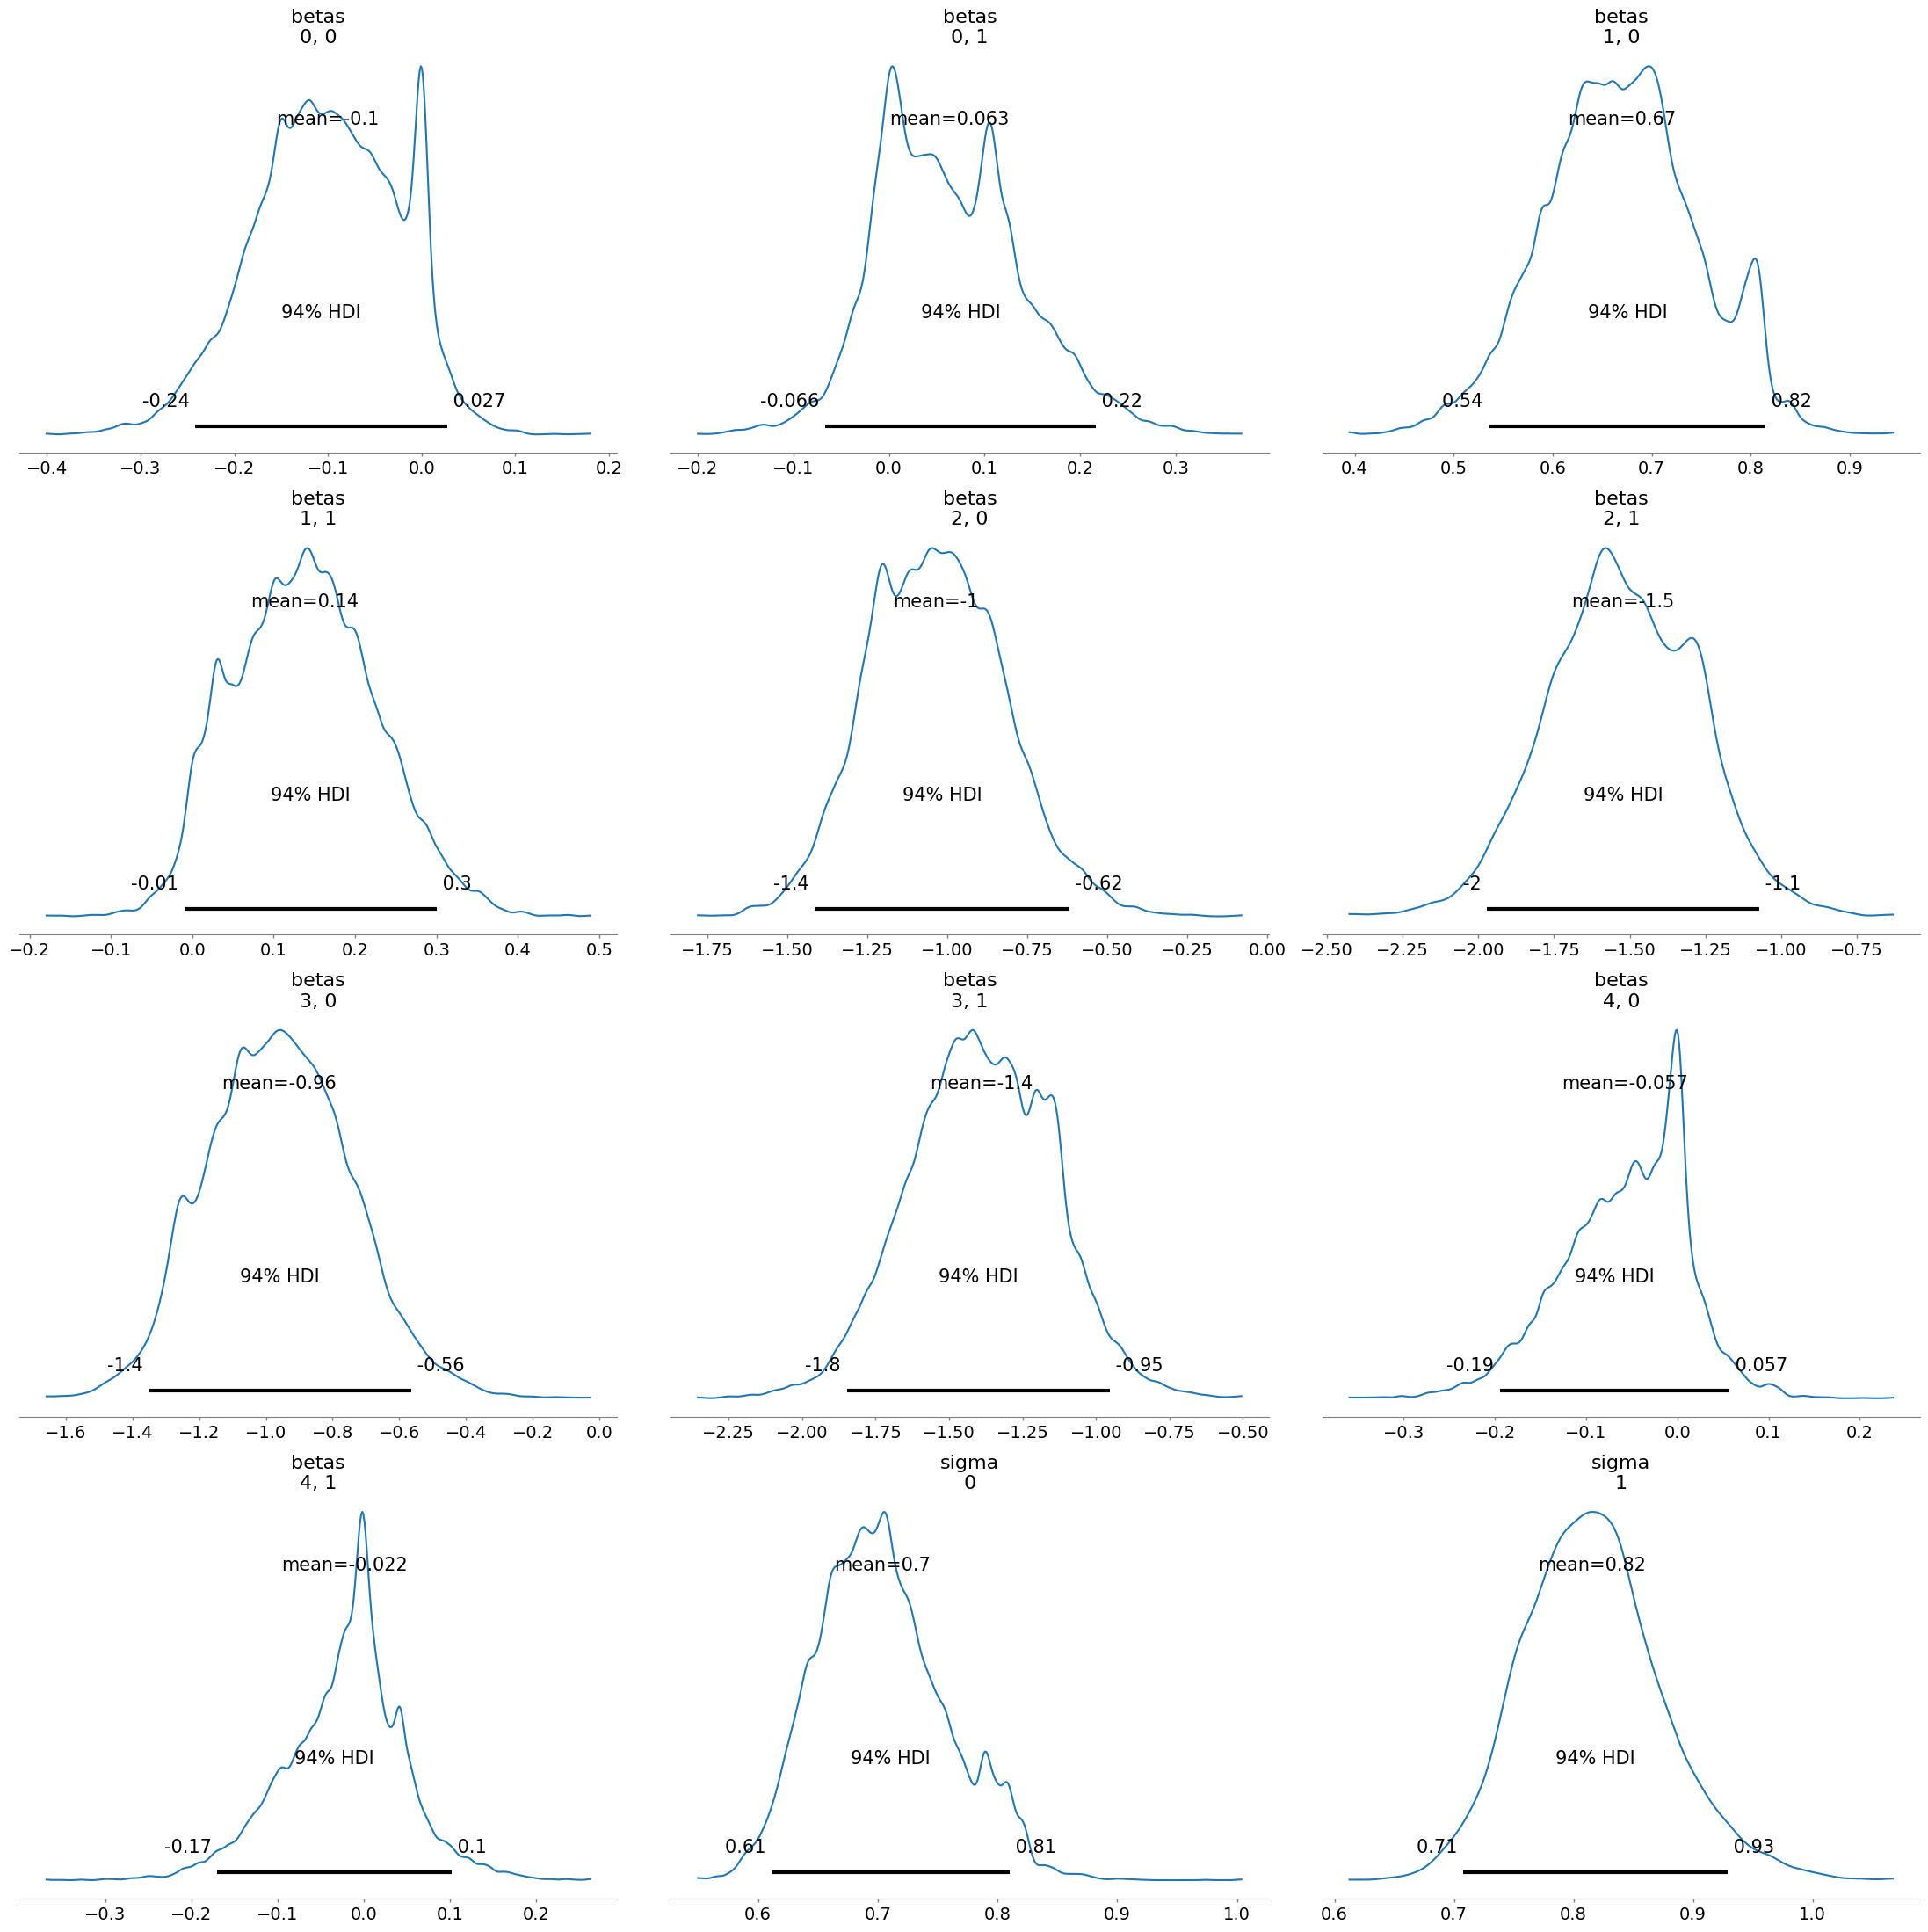

In [88]:
az.plot_posterior(idata_horseshoe, var_names=['betas', 'sigma'])
plt.tight_layout()
plt.show()

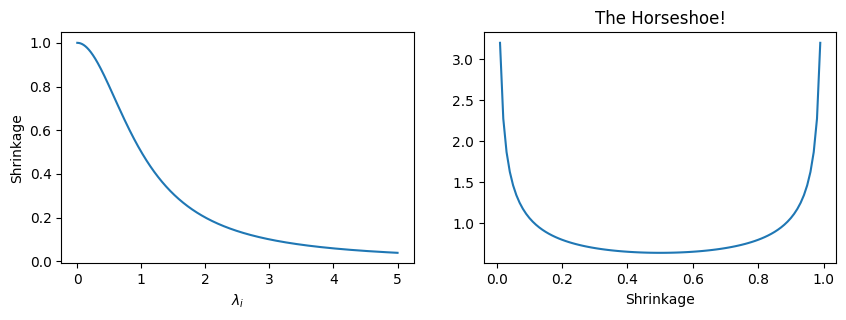

In [76]:
fig,ax = plt.subplots(1,2,figsize=(10,3))
support = np.linspace(0,5,1000)
# shrnk = trans(spprt) = 1/(1+sprt**2)
shrinkage = 1/(1+support**2)
ax[0].plot(support, shrinkage)
ax[0].set_ylabel("Shrinkage")
ax[0].set_xlabel("$\\lambda_i$")
# change of variables:
# spprt = (1/shrnk-1)**0.5; E.g., 1/(1+.5**2), (1/.8-1)**0.5;
# jacobian: .5(1/shrnk-1)**(-.5)*shrnk**(-2)
shrinkage = np.linspace(0.01,.99,99)
ax[1].plot(shrinkage,
           stats.halfcauchy(scale=1).pdf((1/shrinkage-1)**0.5) *
           .5*(1/shrinkage-1)**(-.5)*shrinkage**(-2))
ax[1].set_title('The Horseshoe!')
ax[1].set_xlabel("Shrinkage");

In comparison to the spike and slab multivariate regression model, the horseshoe prior multivariate regression model has relatively similar beta estimates, duller peaks (less confidence) in the posterior plot, and wider/more crooked high density intervals.